# Predictive Maintenance using Machine Learning on Sagemaker
*Part 5 - Getting predictions*

## Initialization
---
Directory structure to run this notebook:
```
nasa-turbofan-rul-deepar
|
+--- data
|   |
|   +--- interim: intermediate data we can manipulate and process
|   |
|   \--- raw: *immutable* data downloaded from the source website
|
+--- notebooks: all the notebooks are positionned here
|
+--- src: utility python modules are stored here
```
### Imports

In [134]:
%load_ext autoreload
import os
import errno
import sys
import pandas as pd

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing utility tools:

In [135]:
%autoreload 2

sys.path.append('../src')
from deepar_utils import series_to_json, DeepARPredictor

Importing Sagemaker & AWS specific libraries: we also obtain the IAM role arn used to give training and hosting access to your data. Here we use the get_execution_role function to obtain the role arn which was specified when creating the notebook. We also configure the container image to be used for the region that we are running in.

In [136]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

sagemaker_session = sagemaker.Session()
role = get_execution_role()
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

### Loading data from the previous notebook

In [137]:
# Load data from the notebook local storage:
%store -r

# If the data are not present in the notebook local storage, we need to load them from disk:
success_msg = 'Loaded "data"'
if 'data' not in locals():
    try:
        local_path = '../data/interim'
        data = pd.read_csv(os.path.join(local_path, 'data.csv'))
            
        print(success_msg)
            
    except Exception as e:
        if (e.errno == errno.ENOENT):
            print('Files not found to load data from: you need to execute data collection and data preparation notebooks.')
            
else:
    print(success_msg)
            
success_msg = 'Loaded "job_name"'
if 'job_name' not in locals():
    try:
        local_path = '../data/interim'
        with open(os.path.join(local_path, 'job_name.txt'), 'w') as f:
            job_name = f.readline()
            
        print(success_msg)
            
    except Exception as e:
        if (e.errno == errno.ENOENT):
            print('Job name not found, you need to execute the training notebook')
            
else:
    print(success_msg + ': ' + job_name)
            
success_msg = 'Loaded "prediction_length"'
if 'prediction_length' not in locals():
    try:
        local_path = '../data/interim'
        with open(os.path.join(local_path, 'training_variables.txt'), 'w') as f:
            training_variables = eval(f.readline())
            prediction_length = training_variables['prediction_length']
            
        print(success_msg)
            
    except Exception as e:
        if (e.errno == errno.ENOENT):
            print('File not found to load training parameters from: you need to execute the data preparation notebook.')
            
else:
    print(success_msg + ': ' + str(prediction_length))
    
    
# If the data are not present in the notebook local storage, we need to load them from disk:
success_msg = 'Loaded "data_channels", "freq", "prediction_length", "context_length", "columns" and "s3_output_path"'
if 'data_channels' not in locals():
    try:
        local_path = '../data/interim'
        with open(os.path.join(local_path, 'training_variables.txt'), 'w') as f:
            training_variables = eval(f.readline())
            
            print(training_variables)

            data_channels = training_variables['data_channels']
            freq = training_variables['freq']
            prediction_length = training_variables['prediction_length']
            context_length = training_variables['context_length']
            s3_output_path = training_variables['s3_output_path']
            columns = training_variables['columns']
            
        print(success_msg)
            
    except Exception as e:
        if (e.errno == errno.ENOENT):
            print('File not found to load data from: you need to execute the data preparation notebook.')
            
else:
    from pprint import pprint
    pprint({
        'data_channels': data_channels,
        'freq': freq,
        'prediction_length': prediction_length,
        'context_length': context_length,
        's3_output_path': s3_output_path,
        'columns': columns
    })
    print('\n' + success_msg)

Loaded "data"
Loaded "job_name": pm-nasa-turbofan-rul-2020-06-05-16-41-39-919
Loaded "prediction_length": 1
{'columns': ['operational_setting_1',
             'operational_setting_2',
             'sensor_measurement_2',
             'sensor_measurement_3',
             'sensor_measurement_4',
             'sensor_measurement_6',
             'sensor_measurement_7',
             'sensor_measurement_8',
             'sensor_measurement_9',
             'sensor_measurement_11',
             'sensor_measurement_12',
             'sensor_measurement_13',
             'sensor_measurement_14',
             'sensor_measurement_15',
             'sensor_measurement_17',
             'sensor_measurement_20',
             'sensor_measurement_21'],
 'context_length': 7,
 'data_channels': {'test': 's3://industrial-predictive-maintenance/nasa-turbofan-rul/small-seqs/test/',
                   'train': 's3://industrial-predictive-maintenance/nasa-turbofan-rul/small-seqs/train/'},
 'freq': '1D',
 'pr

## Preparing test set
---

In [138]:
dataset_path = '../data/interim/test_FD001.txt'
test_data = pd.read_csv(dataset_path, header=None, sep=' ')
test_data.dropna(axis='columns', how='all', inplace=True)
print('Shape:', test_data.shape)
test_data.head(5)

Shape: (13096, 26)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [139]:
test_columns = [
    'unit_number',
    'time',
    'operational_setting_1',
    'operational_setting_2',
    'operational_setting_3',
] + ['sensor_measurement_{}'.format(s) for s in range(1,22)]
test_data.columns = test_columns

first_day = '2019-01-01'
test_data['timestamp'] = pd.to_datetime(first_day) + pd.Timedelta('1 day') * (test_data['time'] - 1)
test_data = test_data[['unit_number', 'timestamp', 'time'] + columns]

In [140]:
test_unit_id = 3
test_df = test_data[test_data['unit_number'] == test_unit_id]
test_df = test_df.drop(columns=['unit_number', 'time'])
test_df = test_df.set_index('timestamp')
print(test_df.shape)
test_df.head()

(126, 17)


,operational_setting_1,operational_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21
timestamp,,,,,,,,,,,,,,,,,
2019-01-01,-0.0001,0.0001,642.03,1589.92,1408.39,21.61,553.40,2388.07,9053.65,47.71,522.20,2388.13,8131.17,8.4330,392,38.99,23.2960
2019-01-02,0.0039,-0.0003,642.23,1597.31,1407.90,21.61,553.74,2388.11,9041.49,47.44,521.19,2388.08,8132.69,8.4183,393,38.84,23.3191
2019-01-03,0.0006,0.0003,642.98,1586.77,1407.58,21.61,553.23,2388.06,9053.39,47.40,521.92,2388.09,8131.29,8.4017,391,38.69,23.3774
2019-01-04,-0.0011,-0.0001,642.42,1590.52,1401.42,21.61,553.31,2388.08,9051.03,47.66,521.59,2388.09,8134.41,8.4398,395,38.72,23.3676
2019-01-05,-0.0004,-0.0003,642.48,1583.09,1405.87,21.61,553.61,2388.16,9054.70,47.54,521.37,2388.09,8135.05,8.4540,392,38.81,23.2853


### Build actual RUL
Let's now build the actual RUL from data provided by NASA:

In [141]:
dataset_path = '../data/interim/RUL_FD001.txt'
actual_rul = pd.read_csv(dataset_path, header=None, sep=' ')
actual_rul.dropna(axis='columns', how='all', inplace=True)
actual_rul.columns = ['rul']
print('Shape:', actual_rul.shape)
actual_rul.head(5)

Shape: (100, 1)


,rul
0,112
1,98
2,69
3,82
4,91


In [142]:
test_data

,unit_number,timestamp,time,operational_setting_1,operational_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21
0,1,2019-01-01,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,1,2019-01-02,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,1,2019-01-03,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,1,2019-01-04,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,1,2019-01-05,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,2019-07-13,194,0.0049,0.0000,643.24,1599.45,1415.79,21.61,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974
13092,100,2019-07-14,195,-0.0011,-0.0001,643.22,1595.69,1422.05,21.61,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771
13093,100,2019-07-15,196,-0.0006,-0.0003,643.44,1593.15,1406.82,21.61,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051
13094,100,2019-07-16,197,-0.0038,0.0001,643.26,1594.99,1419.36,21.61,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699


In [143]:
# Add a RUL column and group the data by unit_number:
test_data['true_rul'] = 0
test_data['piecewise_rul'] = 0
grouped_data = test_data.groupby(by='unit_number')
rul_limit = 130

# Loops through each unit number to get the lifecycle counts:
for unit, max_rul in enumerate(grouped_data.count()['time']):
    current_df = test_data[test_data['unit_number'] == (unit+1)].copy()
    current_df['true_rul'] = max_rul - current_df['time'] + actual_rul['rul'][unit]
    current_df.loc[current_df['true_rul'] > 130, 'piecewise_rul'] = 130
    current_df.loc[current_df['true_rul'] <= 130, 'piecewise_rul'] = current_df['true_rul']
    test_data[test_data['unit_number'] == (unit+1)] = current_df
    
test_data[test_data['unit_number'] == 1].head()

,unit_number,timestamp,time,operational_setting_1,operational_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_6,sensor_measurement_7,...,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21,true_rul,piecewise_rul
0,1,2019-01-01,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,...,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142,130
1,1,2019-01-02,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,...,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141,130
2,1,2019-01-03,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,...,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140,130
3,1,2019-01-04,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,...,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139,130
4,1,2019-01-05,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,...,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138,130


## Predicting results
---
### Create endpoint and predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

In [144]:
print('Creating endpoint to serve the model build with this training job: {}'.format(job_name))
endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

Creating endpoint to serve the model build with this training job: pm-nasa-turbofan-rul-2020-06-05-16-41-39-919
---------------!

To query the endpoint and perform predictions, we can use the `series_to_json()` utility tool defined previously: this allows making requests using pandas.Series objects rather than raw JSON strings.

In [145]:
#endpoint_name = 'pm-nasa-turbofan-rul-2020-06-05-13-13-04-442'
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

### Building successive test sequences

In [146]:
nb_sequences = test_df.shape[0] + 1
sequences = []
for seq_index in range(0, nb_sequences):
    sequence = test_df[:seq_index + 2]
    sequences.append(sequence)

#ruls_list =[last_rul]

In [147]:
testing_sequences = pd.DataFrame()
ruls_df = pd.DataFrame()
last_rul = 130
for index, sequence in enumerate(sequences):
    if index >= len(sequences) - 2: break
    dynamic_features = sequence

    testing_sequences = testing_sequences.append({'timestamp': sequence.index[-2], 'value': last_rul}, ignore_index=True)
    #testing_sequences = testing_sequences.set_index('timestamp')['value']
    
    predictions = predictor.predict([testing_sequences.set_index('timestamp')['value']], None, [dynamic_features])
    last_rul = predictions[0][0][0]
    
    ruls_df = ruls_df.append({'timestamp': sequence.index[-2], 'predicted_rul': last_rul}, ignore_index=True)

    #ruls_list.append(last_rul)
    
ruls_df

,predicted_rul,timestamp
0,130.546768,2019-01-01
1,129.193558,2019-01-02
2,127.425056,2019-01-03
3,125.774902,2019-01-04
4,124.385010,2019-01-05
...,...,...
120,38.251862,2019-05-01
121,37.864323,2019-05-02
122,37.480713,2019-05-03
123,37.100990,2019-05-04


In [148]:
ground_truth = test_data.loc[test_data['unit_number'] == test_unit_id, ['timestamp', 'piecewise_rul']]

In [149]:
rul_data = pd.merge(ruls_df, ground_truth, how='inner', left_on='timestamp', right_on='timestamp')
rul_data = rul_data.set_index('timestamp')
rul_data

,predicted_rul,piecewise_rul
timestamp,,
2019-01-01,130.546768,130
2019-01-02,129.193558,130
2019-01-03,127.425056,130
2019-01-04,125.774902,130
2019-01-05,124.385010,130
...,...,...
2019-05-01,38.251862,74
2019-05-02,37.864323,73
2019-05-03,37.480713,72


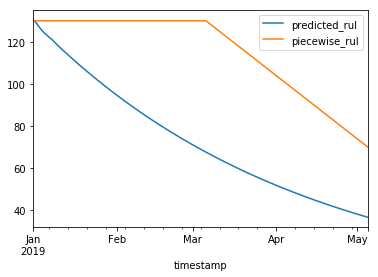

In [150]:
rul_data.plot()

### Make predictions

We need the training sequences we want to predict from and the full dynamic features (as we want to get data points that are in the future compared to the training sequences):

In [31]:
from deepar_utils import build_deepar_sequences

# Build and unpack the sequences:
sequences = build_deepar_sequences(data, prediction_length)
testing_sequences = sequences[0]
dynamic_features = sequences[1]
training_sequences = sequences[3]

In [32]:
nb = 10
list_of_df = predictor.predict(training_sequences[:nb], None, dynamic_features[:nb])
actual_data = testing_sequences[:nb]

### Plot results

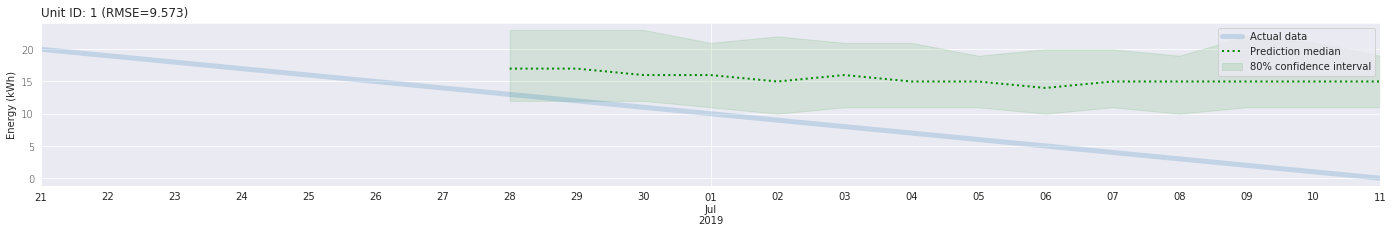

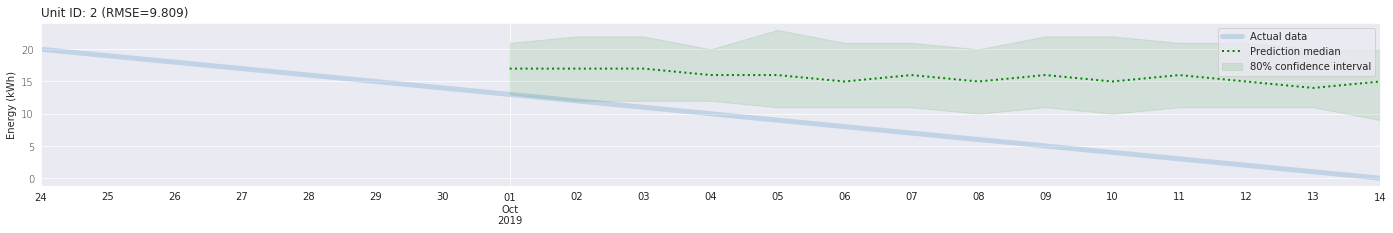

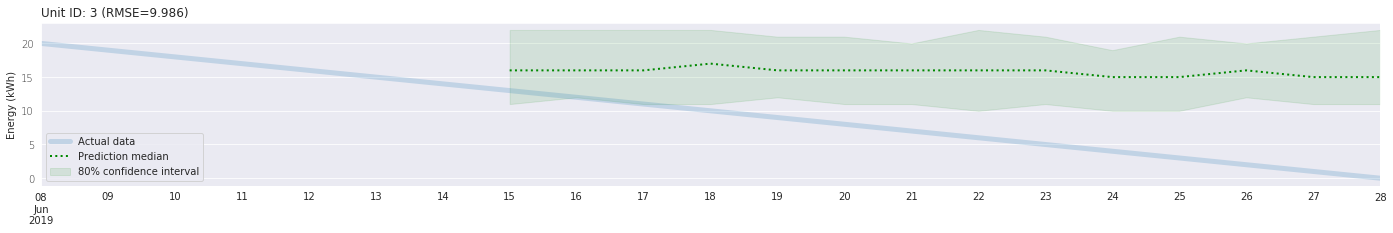

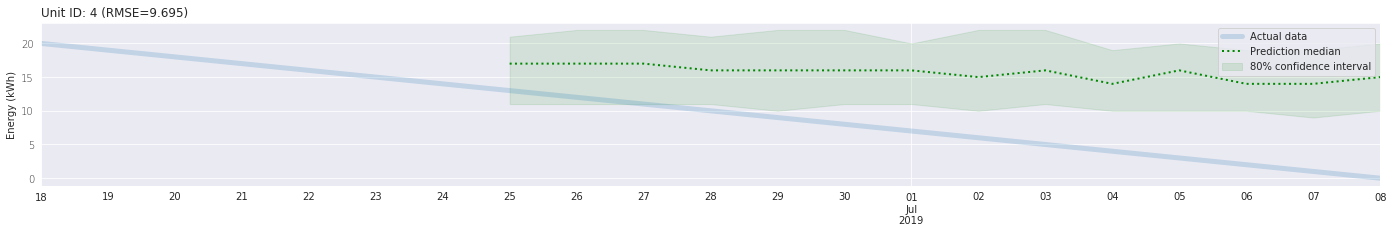

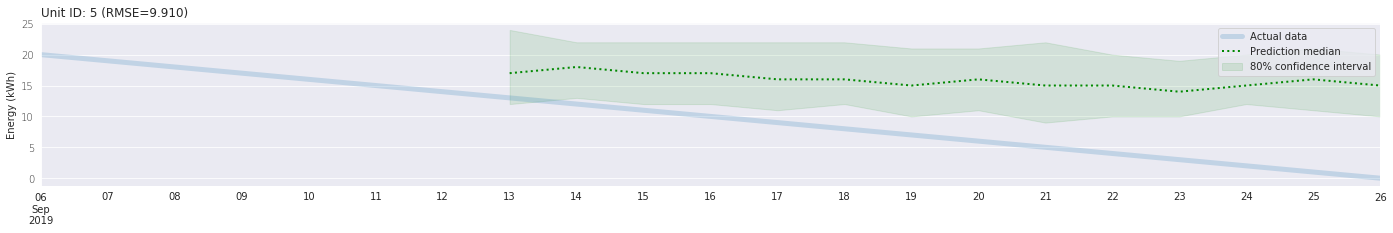

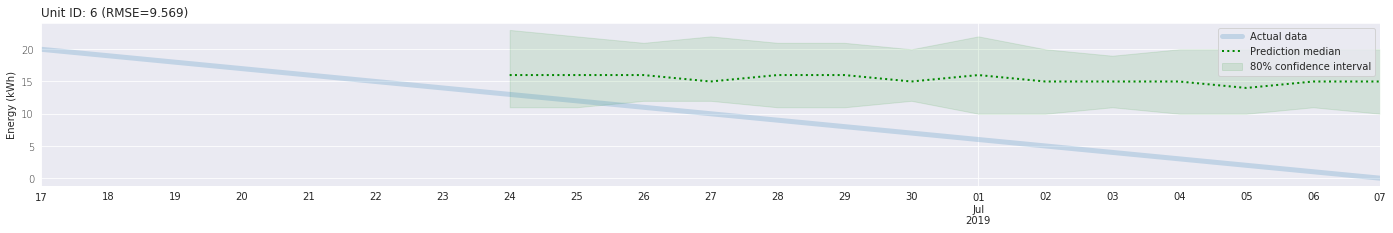

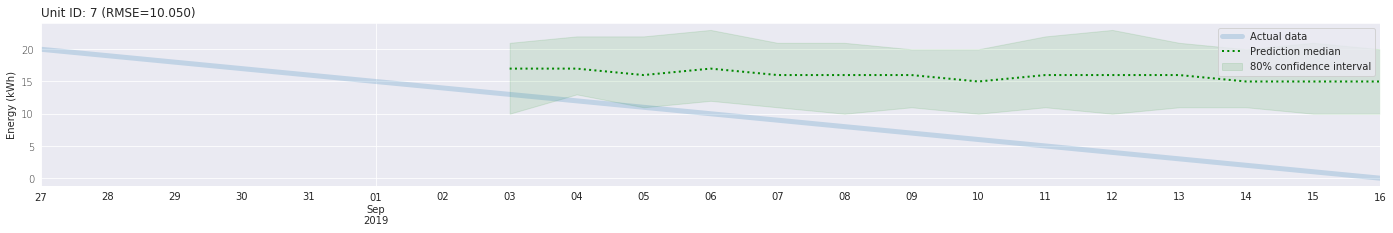

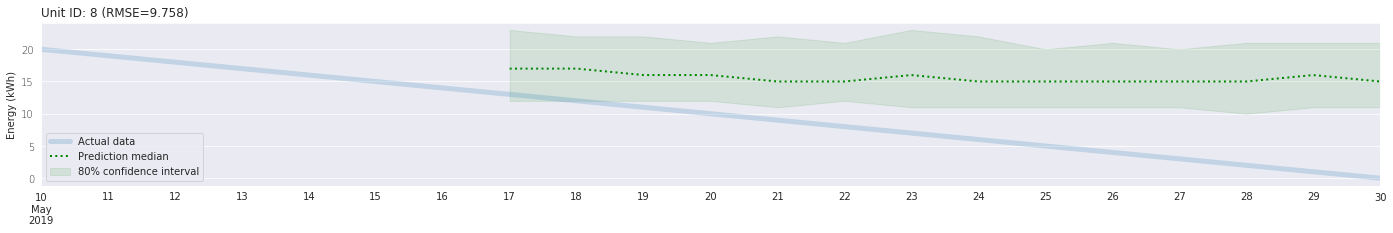

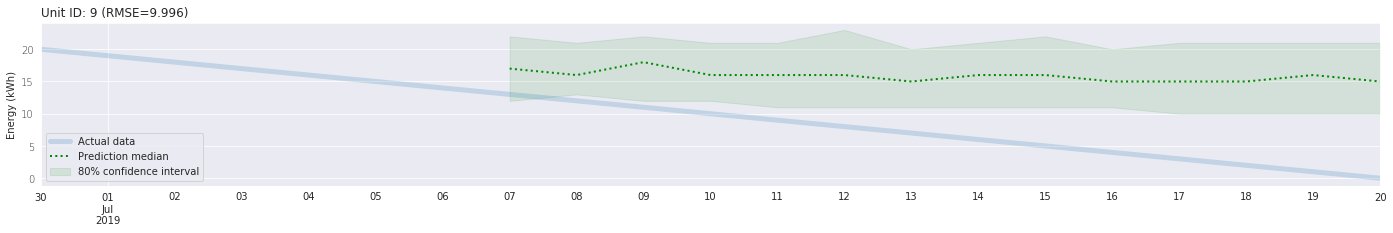

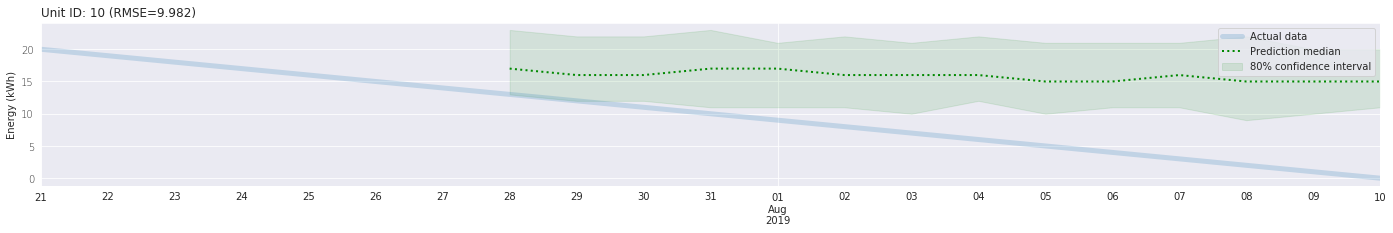

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error

sns.set_style('darkgrid')

for k in range(len(list_of_df)):
    fig = plt.figure(figsize=(24,3))
    actual_data[k][-prediction_length-context_length:].plot(label='Actual data')
    
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='#008800', alpha=0.1, label='80% confidence interval')
    
    ax = list_of_df[k]['0.5'].plot(label='Prediction median')
    
    ax.lines[0].set_linewidth(5)
    ax.lines[0].set_alpha(0.2)
    ax.lines[1].set_color('#008800')
    ax.lines[1].set_linewidth(2)
    ax.lines[1].set_linestyle(':')
    ax.set_ylabel('Energy (kWh)', fontsize=10)
    ax.set_xlabel('')
    plt.yticks(fontweight='light', fontsize='10')

    # Compute RMSE for this prediction:
    rmse = sqrt(mean_squared_error(actual_data[k][-prediction_length:], list_of_df[k]['0.5']))
    title = 'Unit ID: {} (RMSE={:.3f})'.format(k + 1, rmse)
    
    plt.title(title, loc='left')
    
    plt.legend()
    plt.show()

## Cleanup
---

In [34]:
sagemaker_session.delete_endpoint(endpoint_name)